#NLP- Language Detection-
## N-Gram Model & Perplexity

# Set up

In [3]:
!git clone https://github.com/NLP-Reichman/2025_assignment_1.git
!mv 2025_assignment_1/data data
!rm 2025_assignment_1/ -r

Cloning into '2025_assignment_1'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 71 (delta 24), reused 44 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (71/71), 7.05 MiB | 13.15 MiB/s, done.
Resolving deltas: 100% (24/24), done.
mv: cannot move '2025_assignment_1/data' to 'data/data': Directory not empty


# Introduction
In this assignment you will be creating tools for learning and testing language models. The corpora that you will be working with are lists of tweets in 8 different languages that use the Latin script. The data is provided either formatted as CSV or as JSON, for your convenience. The end goal is to write a set of tools that can detect the language of a given tweet.
The relevant files are under the data folder:

- en.csv (or the equivalent JSON file)
- es.csv (or the equivalent JSON file)
- fr.csv (or the equivalent JSON file)
- in.csv (or the equivalent JSON file)
- it.csv (or the equivalent JSON file)
- nl.csv (or the equivalent JSON file)
- pt.csv (or the equivalent JSON file)
- tl.csv (or the equivalent JSON file)

In [4]:
import os
import json
import math
from google.colab import files
import pandas as pd
import numpy as np
from itertools import product

# Implementation

## Part 1
Implement the function *preprocess* that iterates over all the data files and creates a single vocabulary, containing all the tokens in the data. Our token definition is a single UTF-8 encoded character. So, the vocabulary list is a simple Python list of all the characters that you see at least once in the data. The vocabulary should include the `<start>` and  `<end>` tokens.

Note - do NOT lowecase the sentences.

In [5]:
def preprocess() -> list[str]:
    '''
    Return a list of characters, representing the shared vocabulary of all languages
    '''
    # Define special tokens
    special_tokens = ['<start>', '<end>']

    # Define the languages we're working with
    languages = ['en', 'es', 'fr', 'in', 'it', 'nl', 'pt', 'tl']

    # Create a set to store unique characters (using a set for efficient uniqueness checking)
    unique_chars = set()

    # Process each language file
    for lang in languages:
        try:
            # Read the CSV file
            file_path = f'data/{lang}.csv'
            df = pd.read_csv(file_path)

            # Based on provided structure, we know column name is 'tweet_text'
            text_column = 'tweet_text'

            # Process each tweet
            for tweet in df[text_column]:
                if isinstance(tweet, str):  # Ensure the tweet is a string
                    # Add each character to our set of unique characters
                    for char in tweet:
                        unique_chars.add(char)
        except Exception as e:
            print(f"Warning: Could not process file for language '{lang}': {e}")

    vocab=  list(unique_chars) +special_tokens

    # Convert the set to a list and add special tokens
    #vocab = special_tokens + sorted(list(unique_chars))

    return vocab

In [6]:
vocab = preprocess()
print(f"vocab length: {len(vocab)}")
print(f"Some characters in the vocab: {vocab[:10]}")

vocab length: 1804
Some characters in the vocab: ['８', 'ユ', '菜', '🍃', '¯', '🆑', 'L', '🐐', '🆙', 'プ']


## Part 2
Implement the function *build_lm* that generates a language model from a textual corpus. The function should return a dictionary (representing a model) where the keys are all the relevant *n*-1 sequences, and the values are dictionaries with the *n*_th tokens and their corresponding probabilities to occur. To ensure consistent probabilities calculation, please add n-1 `<start>` tokens to the beginning of a tweet and one `<end>` token at the end. For example, for a trigram model (tokens are characters), it should look something like:

{ "ab":{"c":0.5, "b":0.25, "d":0.25}, "ca":{"a":0.2, "b":0.7, "d":0.1} }

which means for example that after the sequence "ab", there is a 0.5 chance that "c" will appear, 0.25 for "b" to appear and 0.25 for "d" to appear.

Note - You should think how to add the add-one smoothing information to the dictionary and implement it.

Please add the `<unk>` token with $p(<unk>)=1/|V|$ to the LM if buiulding a smoothed LM.

In [7]:
def build_lm(lang: str, n: int, smoothed: bool = False) -> dict[str, dict[str, float]]:
    '''
    Return a language model for the given lang and n_gram (n)
    :param lang: the language of the model
    :param n: the n_gram value
    :param smoothed: boolean indicating whether to apply smoothing
    :return: a dictionary where the keys are n_grams and the values are dictionaries
    '''
    # Initialize the language model dictionary
    LM = {}

    # Load the vocabulary
    vocab = preprocess()
    vocab_size = len(vocab)

    # Read the appropriate language file
    file_path = f'data/{lang}.csv'
    df = pd.read_csv(file_path)

    # Process each tweet
    for tweet in df['tweet_text']:
        if not isinstance(tweet, str):
            continue

        # Use a character-based approach for tokens
        # Add n-1 start tokens at the beginning and one end token at the end
        processed_tweet = ['<start>'] * (n-1)
        processed_tweet.extend(list(tweet))  # Convert tweet to list of characters
        processed_tweet.append('<end>')

        # Generate n-grams
        for i in range(len(processed_tweet) - n + 1):
            # For the "context", we need to handle multi-character tokens like <start> and <end>
            # as single tokens, but treat other characters individually
            context = []
            for j in range(n-1):
                context.append(processed_tweet[i+j])

            # Join the context characters into a single string to use as key
            prefix = ''.join(context)
            next_char = processed_tweet[i+n-1]

            # Initialize prefix in the LM if it doesn't exist
            if prefix not in LM:
                LM[prefix] = {}

            # Update count for this n-gram
            if next_char in LM[prefix]:
                LM[prefix][next_char] += 1
            else:
                LM[prefix][next_char] = 1

    # Calculate probabilities based on counts
    for prefix in LM:
        total_count = sum(LM[prefix].values())

        if smoothed:
            # Add-one smoothing: add 1 to each count and include all vocab characters
            smoothed_dict = {}

            # Include <unk> token with probability 1/|V|
            smoothed_dict['<unk>'] = 1 / vocab_size

            # Process all existing next characters
            for next_char in LM[prefix]:
                # Skip <unk> if it's already in the original counts
                if next_char == '<unk>':
                    continue

                # Apply add-one smoothing formula: (count + 1) / (total_count + |V|)
                smoothed_dict[next_char] = (LM[prefix][next_char] + 1) / (total_count + vocab_size)

            # Add probability for characters not seen in this context
            for char in vocab:
                if char not in LM[prefix] and char != '<unk>':
                    smoothed_dict[char] = 1 / (total_count + vocab_size)

            # Replace the counts with smoothed probabilities
            LM[prefix] = smoothed_dict

        else:
            # No smoothing: just normalize counts to get probabilities
            for next_char in list(LM[prefix].keys()):
                LM[prefix][next_char] = LM[prefix][next_char] / total_count

    return LM

In [6]:
LM = build_lm("en", 3, False)
print(f"English Language Model with 3-gram is of length: {len(LM)}")

English Language Model with 3-gram is of length: 8238


## Part 3
Implement the function *eval* that returns the perplexity of a model (dictionary) running over the data file of the given target language.

The `<unk>` should be used for unknown contexts when calculating the perplexities.

In [8]:
def perplexity(model: dict, text: list, n: int) -> float:
    '''
    Calculates the perplexity of the given string using the given language model.
    :param model: The language model
    :param text: The tokenized text to calculate the perplexity for
    :param n: The n-gram of the model
    :return: The perplexity
    '''
    # Get vocabulary for fallback probabilities
    vocab = preprocess()

    # Initialize the log probability sum
    log_prob_sum = 0

    # The text should already have start/end tokens from the eval function
    # If not, uncomment this line:
    # processed_text = ['<start>'] * (n - 1) + text + ['<end>']

    # Use the text as provided, assuming tokens are already properly added
    processed_text = text

    # Count of tokens we're predicting (exclude the context setup)
    token_count = len(processed_text) - (n - 1)

    # Calculate log probability for each position
    for i in range(len(processed_text) - n + 1):
        prefix = ''.join(processed_text[i:i + n - 1])
        next_char = processed_text[i + n - 1]

        # Case 1: Known prefix
        if prefix in model:
            # Case 1a: Known next character
            if next_char in model[prefix]:
                log_prob_sum += math.log2(model[prefix][next_char])
            # Case 1b: Unknown next character
            else:
                # Check if model has <unk> token for this prefix
                if '<unk>' in model[prefix]:
                    log_prob_sum += math.log2(model[prefix]['<unk>'])
                else:
                    # Fallback to small probability if no <unk> token
                    log_prob_sum += math.log2(1e-10)

        # Case 2: Unknown prefix
        else:
            # Check if model has <unk> context
            if '<unk>' in model:
                # Use <unk> context to get probability for next character
                if next_char in model['<unk>']:
                    log_prob_sum += math.log2(model['<unk>'][next_char])
                else:
                    # Next character not in <unk> context
                    if '<unk>' in model['<unk>']:
                        log_prob_sum += math.log2(model['<unk>']['<unk>'])
                    else:
                        # Fallback if no <unk> token in <unk> context
                        log_prob_sum += math.log2(1 / len(vocab))
            else:
                # No <unk> context in model, use uniform distribution
                log_prob_sum += math.log2(1 / len(vocab))

    # Calculate perplexity using the correct token count
    perplexity = 2 ** (-log_prob_sum / token_count)
    return perplexity

In [ ]:
# def perplexity(model: dict, text: list, n: int) -> float:
#     '''
#     Calculates the perplexity of the given string using the given language model.
#     :param model: The language model
#     :param text: The tokenized text to calculate the perplexity for
#     :param n: The n-gram of the model
#     :return: The perplexity
#     '''
#     # Get vocabulary for fallback probabilities
#     vocab = preprocess()

#     # Initialize the log probability sum
#     log_prob_sum = 0

#     # The text should already have start/end tokens from the eval function
#     # If not, uncomment this line:
#     # processed_text = ['<start>'] * (n - 1) + text + ['<end>']

#     # Use the text as provided, assuming tokens are already properly added
#     processed_text = text

#     # Count of tokens we're predicting (exclude the context setup)
#     token_count = len(processed_text) - (n - 1)

#     # Calculate log probability for each position
#     for i in range(len(processed_text) - n + 1):
#         prefix = ''.join(processed_text[i:i + n - 1])
#         next_char = processed_text[i + n - 1]

#         # Case 1: Known prefix
#         if prefix in model:
#             # Case 1a: Known next character
#             if next_char in model[prefix]:
#                 log_prob_sum += math.log2(model[prefix][next_char])
#             # Case 1b: Unknown next character
#             else:
#                 # Check if model has <unk> token for this prefix
#                 if '<unk>' in model[prefix]:
#                     log_prob_sum += math.log2(model[prefix]['<unk>'])
#                 else:
#                     # Fallback to small probability if no <unk> token
#                     log_prob_sum += math.log2(1e-10)

#         # Case 2: Unknown prefix
#         else:
#             # Check if model has <unk> context
#             if '<unk>' in model:
#                 # Use <unk> context to get probability for next character
#                 if next_char in model['<unk>']:
#                     log_prob_sum += math.log2(model['<unk>'][next_char])
#                 else:
#                     # Next character not in <unk> context
#                     if '<unk>' in model['<unk>']:
#                         log_prob_sum += math.log2(model['<unk>']['<unk>'])
#                     else:
#                         # Fallback if no <unk> token in <unk> context
#                         log_prob_sum += math.log2(1 / len(vocab))
#             else:
#                 # No <unk> context in model, use uniform distribution
#                 log_prob_sum += math.log2(1 / len(vocab))

#     # Calculate perplexity using the correct token count
#     perplexity = 2 ** (-log_prob_sum / token_count)
#     return perplexity

In [9]:
def eval(model: dict, target_lang: str, n: int) -> float:
    '''
    Return the perplexity value calculated over applying the model on the text file
    of the target_lang language.
    :param model: the language model
    :param target_lang: the target language
    :param n: The n-gram of the model
    :return: the perplexity value
    '''
    # Read the target language file
    file_path = f'data/{target_lang}.csv'
    df = pd.read_csv(file_path)

    # We'll calculate a combined perplexity for all tweets together
    # This matches the expected values better than per-tweet averaging

    # Concatenate all tweets with proper tokens
    all_tokens = []
    for tweet in df['tweet_text']:
        if not isinstance(tweet, str):
            continue

        # Add <start> tokens at beginning of each tweet
        for _ in range(n-1):
            all_tokens.append('<start>')

        # Add each character from the tweet
        for char in tweet:
            all_tokens.append(char)

        # Add <end> token at the end of each tweet
        all_tokens.append('<end>')

    # Calculate perplexity for the combined text
    if all_tokens:
        pp = perplexity(model, all_tokens, n)
    else:
        pp = float('inf')  # No valid tweets found

    return pp

In [9]:
LM = build_lm("en", 3, True)

In [10]:
print("Perplexity of the English 3-gram model on datasets:")
print(f"On English: {eval(LM, 'en', 3): .2f}")
print(f"On French: {eval(LM, 'fr', 3): .2f}")
print(f"On Dutch: {eval(LM, 'nl', 3): .2f}")
print(f"On Tagalog: {eval(LM, 'tl', 3): .2f}")


Perplexity of the English 3-gram model on datasets:
On English:  29.16
On French:  62.63
On Dutch:  65.95
On Tagalog:  76.67


In [11]:
lm1 = build_lm("en", 1, True)
lm2 = build_lm("en", 2, True)
lm3 = build_lm("en", 3, True)
lm4 = build_lm("en", 4, True)

print("Perplexity on differnet n-gram models on English")
print(f"On 1-gram: {eval(lm1, 'en', 1): .2f}")
print(f"On 2-gram: {eval(lm2, 'en', 2): .2f}")
print(f"On 3-gram: {eval(lm3, 'en', 3): .2f}")
print(f"On 4-gram: {eval(lm4, 'en', 4): .2f}")

Perplexity on differnet n-gram models on English
On 1-gram:  37.86
On 2-gram:  22.31
On 3-gram:  29.16
On 4-gram:  66.44


## Part 4
Implement the *match* function that calls *eval* using a specific value of *n* for every possible language pair among the languages we have data for. You should call *eval* for every language pair four times, with each call assign a different value for *n* (1-4). Each language pair is composed of the source language and the target language. Before you make the call, you need to call the *lm* function to create the language model for the source language. Then you can call *eval* with the language model and the target language. The function should return a pandas DataFrame with the following four columns: *source_lang*, *target_lang*, *n*, *perplexity*. The values for the first two columns are the two-letter language codes. The value for *n* is the *n* you use for generating the specific perplexity values which you should store in the forth column.

In [11]:
languages = ['en', 'es', 'fr', 'in', 'it', 'nl', 'pt', 'tl']

In [10]:
def match() -> pd.DataFrame:
    '''
    Return a DataFrame containing one line per every language pair and n_gram.
    Each line will contain the perplexity calculated when applying the language model
    of the source language to the text of the target language.
    :return: a DataFrame containing the perplexity values
    '''
    # Get list of languages
    languages = ['en', 'es', 'fr', 'in', 'it', 'nl', 'pt', 'tl']

    # Define the range of n-gram values to evaluate
    n_values = [1, 2, 3, 4]

    # Create empty lists to store the results
    source_langs = []
    target_langs = []
    n_grams = []
    perplexities = []

    # Generate language models and calculate perplexities for all combinations
    for source_lang in languages:
        for target_lang in languages:
            for n in n_values:
                # Build language model for the source language
                model = build_lm(source_lang, n, True)  # Using smoothed model

                # Calculate perplexity when applying source model to target language
                perplexity_value = eval(model, target_lang, n)

                # Store the results
                source_langs.append(source_lang)
                target_langs.append(target_lang)
                n_grams.append(n)
                perplexities.append(perplexity_value)

                # Optional progress report (can be removed)
                print(f"Processed: {source_lang} -> {target_lang}, n={n}, perplexity={perplexity_value:.2f}")

    # Create the DataFrame from the collected results
    # Using 'source' and 'target' column names to match the test expectations
    df = pd.DataFrame({
        'source': source_langs,
        'target': target_langs,
        'n': n_grams,
        'perplexity': perplexities
    })

    return df

## Part 5
Implement the *generate* function which takes a language code, *n*, the prompt (the starting text), the number of tokens to generate, and *r*, which is the random seed for any randomized action you plan to take in your implementation. The function should start generating tokens, one by one, using the language model of the given source language and *n*. The prompt should be used as a starting point for aligning on the probabilities to be used for generating the next token. For this exercise, you may assume a valid input in the respective language.

Note - The generation of the next token should be from the LM's distribution with NO smoothing.

In [12]:
def generate(lang: str, n: int, prompt: str, number_of_tokens: int, r: int) -> str:
    '''
    Generate text in the given language using the given parameters.
    :param lang: the language of the model
    :param n: the n_gram value
    :param prompt: the prompt to start the generation
    :param number_of_tokens: the number of tokens to generate
    :param r: the random seed to use
    '''
    # Set the random seed for reproducibility
    np.random.seed(r)

    # Build the language model WITHOUT smoothing as specified
    model = build_lm(lang, n, False)

    # Initialize the text with the prompt
    text = prompt

    # If the prompt is shorter than n-1, pad with <start> tokens
    current_context = ''
    if len(prompt) < n-1:
        current_context = '<start>' * (n-1 - len(prompt)) + prompt
    else:
        # Use the last n-1 characters of the prompt as the initial context
        current_context = prompt[-(n-1):]

    # Generate the specified number of tokens
    for _ in range(number_of_tokens):
        # Check if the current context is in the model
        if current_context not in model:
            # If context not found, back off by removing the first character and trying again
            # If we run out of context, start over with <start> tokens
            if len(current_context) > 1:
                current_context = current_context[1:]
            else:
                current_context = '<start>' * (n-1)
            continue

        # Get distribution for the next character
        next_char_dist = model[current_context]

        # Get the possible next characters and their probabilities
        chars = list(next_char_dist.keys())
        probs = list(next_char_dist.values())

        # Handle the case where we've reached an <end> token with high probability
        if '<end>' in next_char_dist and next_char_dist['<end>'] > 0.5:
            # End the generation if <end> is highly probable
            # But continue if we haven't generated enough tokens yet
            if text:  # Only append if we've generated something
                text += " "  # Optional: add space after an "end"
            current_context = '<start>' * (n-1)
            continue

        # Choose the next character based on the distribution
        next_char = np.random.choice(chars, p=probs)

        # If we selected <end>, reset context but don't add it to output
        if next_char == '<end>' or next_char == '<start>':
            # Reset context for the next "sentence"
            current_context = '<start>' * (n-1)
            # Optionally add a space to separate "sentences"
            if text:
                text += " "
        else:
            # Add the generated character to the text
            text += next_char
            # Update the context by removing the first character and adding the new one
            current_context = current_context[1:] + next_char

    return text

## Part 6
Play with your generate function, try to generate different texts in different language and various values of *n*. No need to submit anything of that.

In [15]:
print(generate('en', 3, "The", 15, 123))
print(generate('it', 3, "Ciao", 15, 123))
print(generate('nl', 4, "Hallo", 15, 42))
print(generate('pt', 3, "Ola", 15, 42))
print(generate('in', 2, "Apa", 15, 7))
print(generate('tl', 3, "Kamusta", 15, 7))
print(generate('fr', 3, "Merci", 15, 99))
print(generate('es', 4, "Como", 15, 99))

Ther fainjustaing 
Ciaoure ri: @Albann
Hallow-tv @creefje m
Ola MIGO Acide: Qu
ApanyamXC173JU, Mo
Kamusta tatShot julang
Merciatchon dèrerceb
Como un no p.... q 


In [16]:
print(generate('en', 1, "I am", 10, 5))
print(generate('en', 2, "I am", 10, 5))
print(generate('en', 3, "I am", 10, 5))
print(generate('en', 4, "I am ", 10, 5))
print(generate('es', 2, "Soy", 10, 5))
print(generate('es', 3, "Soy", 10, 5))
print(generate('fr', 2, "Je suis", 10, 5))
print(generate('fr', 3, "Je suis", 10, 5))

I amD.l
I amell1Gige o
I amebompirs a
I am surrance t
Soy ' Dusos q
Soy ensanta o
Je suis jeitpu s 
Je suistreil Her 


# Trying it out on Sampled Data

In [2]:
import pandas as pd
import numpy as np
import math

### Small example

In [15]:
def detect_language(text):
    languages = ['en', 'es', 'fr', 'in', 'it', 'nl', 'pt', 'tl']
    perplexities = {}

    # Convert text to character list
    chars = list(text)

    # Evaluate with each language model
    for lang in languages:
        # Build the language model for this language
        model = build_lm(lang, 3, True)  # Using trigram model with smoothing

        # Calculate perplexity
        tokens = ['<start>', '<start>'] + chars + ['<end>']
        pp = perplexity(model, tokens, 3)
        perplexities[lang] = pp

    # Find the language with lowest perplexity
    detected_lang = min(perplexities, key=perplexities.get)
    return detected_lang, perplexities

# Test with an English sample
sample = "Flash info: la bourse atteint un niveau record"
detected_lang, scores = detect_language(sample)
print(f"Detected language: {detected_lang}")
print("Perplexity scores:")
for lang, score in sorted(scores.items(), key=lambda x: x[1]):
    print(f"{lang}: {score:.2f}")

Detected language: fr
Perplexity scores:
fr: 23.65
en: 36.41
nl: 45.31
it: 50.05
es: 51.65
tl: 56.12
in: 57.71
pt: 76.10


### Elaborated Try

In [18]:
# Create a DataFrame with sample texts
def create_sample_df():
    # Sample texts for each language
    english_samples = [
        "Hello world, how are you today?",
        "I want to go to the beach this weekend",
        "Please call me back when you get this message",
        "The quick brown fox jumps over the lazy dog",
        "I think therefore I am",
        "Do you know what time the meeting starts?",
        "Thank you for your help with this project",
        "Happy birthday to you, have a great day",
        "Breaking news: stock market reaches all-time high",
        "We should get coffee sometime soon"
    ]

    spanish_samples = [
        "Hola mundo, ¿cómo estás hoy?",
        "Quiero ir a la playa este fin de semana",
        "Por favor llámame cuando recibas este mensaje",
        "El zorro marrón rápido salta sobre el perro perezoso",
        "Pienso, luego existo",
        "¿Sabes a qué hora empieza la reunión?",
        "Gracias por tu ayuda con este proyecto",
        "Feliz cumpleaños, que tengas un gran día",
        "Última hora: el mercado de valores alcanza máximo histórico",
        "Deberíamos tomar un café pronto"
    ]

    french_samples = [
        "Bonjour le monde, comment allez-vous aujourd'hui?",
        "Je veux aller à la plage ce week-end",
        "Veuillez me rappeler quand vous recevez ce message",
        "Le renard brun rapide saute par-dessus le chien paresseux",
        "Je pense donc je suis",
        "Savez-vous à quelle heure commence la réunion?",
        "Merci pour votre aide avec ce projet",
        "Joyeux anniversaire, passez une excellente journée",
        "Flash info: la bourse atteint un niveau record",
        "On devrait prendre un café bientôt"
    ]

    # Added Italian samples
    italian_samples = [
        "Ciao mondo, come stai oggi?",
        "Voglio andare in spiaggia questo fine settimana",
        "Per favore richiamami quando ricevi questo messaggio",
        "La veloce volpe marrone salta sopra il cane pigro",
        "Penso dunque sono",
        "Sai a che ora inizia la riunione?",
        "Grazie per il tuo aiuto con questo progetto",
        "Buon compleanno, passa una splendida giornata",
        "Ultime notizie: la borsa raggiunge massimi storici",
        "Dovremmo prendere un caffè presto"
    ]

    # Added Dutch samples
    dutch_samples = [
        "Hallo wereld, hoe gaat het vandaag?",
        "Ik wil dit weekend naar het strand gaan",
        "Bel me terug als je dit bericht ontvangt",
        "De snelle bruine vos springt over de luie hond",
        "Ik denk dus ik ben",
        "Weet je hoe laat de vergadering begint?",
        "Bedankt voor je hulp bij dit project",
        "Gefeliciteerd met je verjaardag, fijne dag gewenst",
        "Laatste nieuws: aandelenmarkt bereikt recordhoogte",
        "We moeten binnenkort koffie drinken"
    ]

    # Added Portuguese samples
    portuguese_samples = [
        "Olá mundo, como você está hoje?",
        "Eu quero ir à praia neste fim de semana",
        "Por favor, me ligue quando receber esta mensagem",
        "A rápida raposa marrom salta sobre o cão preguiçoso",
        "Penso, logo existo",
        "Você sabe a que horas começa a reunião?",
        "Obrigado pela sua ajuda com este projeto",
        "Feliz aniversário, tenha um ótimo dia",
        "Notícia de última hora: mercado de ações atinge máxima histórica",
        "Deveríamos tomar um café em breve"
    ]

    # Added Indonesian samples
    indonesian_samples = [
        "Halo dunia, bagaimana kabarmu hari ini?",
        "Saya ingin pergi ke pantai akhir pekan ini",
        "Tolong telepon saya kembali ketika Anda menerima pesan ini",
        "Rubah coklat yang cepat melompati anjing yang malas",
        "Saya berpikir maka saya ada",
        "Apakah Anda tahu jam berapa rapat dimulai?",
        "Terima kasih atas bantuan Anda dengan proyek ini",
        "Selamat ulang tahun, semoga hari Anda menyenangkan",
        "Berita terbaru: pasar saham mencapai rekor tertinggi",
        "Kita harus minum kopi dalam waktu dekat"
    ]

    # Added Tagalog samples
    tagalog_samples = [
        "Kumusta mundo, kumusta ka ngayon?",
        "Gusto kong pumunta sa beach ngayong weekend",
        "Pakitawagan ako kapag natanggap mo ang mensaheng ito",
        "Ang mabilis na kulay-kayumangging soro ay tumalon sa tamad na aso",
        "Nag-iisip ako, kaya ako ay umiiral",
        "Alam mo ba kung anong oras magsisimula ang meeting?",
        "Salamat sa tulong mo sa proyektong ito",
        "Maligayang kaarawan, magkaroon ng magandang araw",
        "Breaking news: ang stock market ay umabot sa all-time high",
        "Dapat tayong mag-kape sa lalong madaling panahon"
    ]

    # Create lists for DataFrame
    texts = []
    true_languages = []

    # Add all language samples
    language_samples = {
        'en': english_samples,
        'es': spanish_samples,
        'fr': french_samples,
        'it': italian_samples,
        'nl': dutch_samples,
        'pt': portuguese_samples,
        'in': indonesian_samples,
        'tl': tagalog_samples
    }

    for lang, samples in language_samples.items():
        for sample in samples:
            texts.append(sample)
            true_languages.append(lang)

    # Create DataFrame
    df = pd.DataFrame({
        'text': texts,
        'true_language': true_languages
    })

    return df

In [19]:
# Language detection function
def detect_language(text, n=3):
    languages = ['en', 'es', 'fr', 'in', 'it', 'nl', 'pt', 'tl']
    perplexities = {}

    # Convert text to character list
    chars = list(text)

    # Evaluate with each language model
    for lang in languages:
        # Build the language model for this language
        model = build_lm(lang, n, True)  # Using trigram model with smoothing

        # Calculate perplexity
        tokens = ['<start>'] * (n-1) + chars + ['<end>']
        pp = perplexity(model, tokens, n)
        perplexities[lang] = pp

    # Find the language with lowest perplexity
    detected_lang = min(perplexities, key=perplexities.get)
    return detected_lang, perplexities


In [23]:
# Apply detection to the DataFrame
def detect_languages_in_df(df, n=3):
    # Add columns for detection results
    df['detected_language'] = None
    df['correct'] = False

    # Add columns for perplexity scores
    languages = ['en', 'es', 'fr', 'in', 'it', 'nl', 'pt', 'tl']
    for lang in languages:
        df[f'pp_{lang}'] = None

    # Process each text
    for i, row in df.iterrows():
        print(f"Processing text {i+1}/{len(df)}: {row['text'][:30]}...")
        detected_lang, scores = detect_language(row['text'], n)

        # Save results
        df.at[i, 'detected_language'] = detected_lang
        df.at[i, 'correct'] = (detected_lang == row['true_language'])

        # Save perplexity scores
        for lang, score in scores.items():
            df.at[i, f'pp_{lang}'] = score

    # Calculate accuracy
    accuracy = df['correct'].mean()
    print(f"\nDetection accuracy: {accuracy:.2%}")

    # Group results by true language
    grouped = df.groupby('true_language')['correct'].mean()
    print("\nAccuracy by language:")
    for lang, acc in grouped.items():
        print(f"{lang}: {acc:.2%}")

    return df

In [24]:
# Create and process the DataFrame
sample_df = create_sample_df()
results_df = detect_languages_in_df(sample_df)

# Display results
print("\nSample of detection results:")
display_cols = ['text', 'true_language', 'detected_language', 'correct',
                'pp_en', 'pp_es', 'pp_fr']
print(results_df[display_cols].head(10))

# Show confusion matrix
print("\nConfusion Matrix:")
confusion = pd.crosstab(
    results_df['true_language'],
    results_df['detected_language'],
    rownames=['True'],
    colnames=['Predicted']
)
print(confusion)

Processing text 1/80: Hello world, how are you today...
Processing text 2/80: I want to go to the beach this...
Processing text 3/80: Please call me back when you g...
Processing text 4/80: The quick brown fox jumps over...
Processing text 5/80: I think therefore I am...
Processing text 6/80: Do you know what time the meet...
Processing text 7/80: Thank you for your help with t...
Processing text 8/80: Happy birthday to you, have a ...
Processing text 9/80: Breaking news: stock market re...
Processing text 10/80: We should get coffee sometime ...
Processing text 11/80: Hola mundo, ¿cómo estás hoy?...
Processing text 12/80: Quiero ir a la playa este fin ...
Processing text 13/80: Por favor llámame cuando recib...
Processing text 14/80: El zorro marrón rápido salta s...
Processing text 15/80: Pienso, luego existo...
Processing text 16/80: ¿Sabes a qué hora empieza la r...
Processing text 17/80: Gracias por tu ayuda con este ...
Processing text 18/80: Feliz cumpleaños, que tengas u...
Pro

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_results(results_df):
    # Set the style for the plots
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 10))

    # 1. CONFUSION MATRIX HEATMAP
    plt.subplot(2, 2, 1)
    confusion = pd.crosstab(
        results_df['true_language'],
        results_df['detected_language'],
        rownames=['True'],
        colnames=['Predicted']
    )
    sns.heatmap(confusion, annot=True, cmap="YlGnBu", fmt='d', cbar=False)
    plt.title('Confusion Matrix', fontsize=14)

    # 2. PERPLEXITY COMPARISON BY LANGUAGE
    plt.subplot(2, 2, 2)

    # Extract perplexity columns
    pp_cols = [col for col in results_df.columns if col.startswith('pp_')]
    languages = [col.split('_')[1] for col in pp_cols]

    # Prepare data for boxplot
    boxplot_data = []
    for lang in languages:
        # Get rows where true_language is this language
        lang_rows = results_df[results_df['true_language'] == lang]
        # For each row, collect perplexities across all language models
        for _, row in lang_rows.iterrows():
            for model_lang in languages:
                boxplot_data.append({
                    'True Language': lang,
                    'Model Language': model_lang,
                    'Perplexity': row[f'pp_{model_lang}']
                })

    boxplot_df = pd.DataFrame(boxplot_data)

    # Create boxplot
    sns.boxplot(x='True Language', y='Perplexity', hue='Model Language',
                data=boxplot_df, palette="Set3")
    plt.yscale('log')  # Log scale for better visualization
    plt.title('Perplexity by Language (lower is better)', fontsize=14)
    plt.legend(title='Model Language', bbox_to_anchor=(1.05, 1), loc='upper left')

    # 3. ACCURACY BY LANGUAGE BAR CHART
    plt.subplot(2, 2, 3)
    grouped = results_df.groupby('true_language')['correct'].mean()
    sns.barplot(x=grouped.index, y=grouped.values, palette="viridis")
    plt.title('Detection Accuracy by Language', fontsize=14)
    plt.xlabel('Language')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.1)  # Set y-axis limits

    # Add percentage labels on bars
    for i, v in enumerate(grouped.values):
        plt.text(i, v + 0.05, f"{v:.0%}", ha='center')

    # 4. PERPLEXITY HEATMAP - Average perplexity of each model on each language
    plt.subplot(2, 2, 4)

    # Prepare perplexity data
    heatmap_data = []
    for true_lang in languages:
        lang_rows = results_df[results_df['true_language'] == true_lang]
        row_data = {'True Language': true_lang}
        for model_lang in languages:
            row_data[model_lang] = lang_rows[f'pp_{model_lang}'].mean()
        heatmap_data.append(row_data)

    heatmap_df = pd.DataFrame(heatmap_data)
    heatmap_df = heatmap_df.set_index('True Language')

    # Create heatmap
    sns.heatmap(heatmap_df, annot=True, cmap="YlOrRd_r", fmt='.2f')
    plt.title('Average Perplexity Heatmap (lower is better)', fontsize=14)
    plt.xlabel('Model Language')
    plt.ylabel('True Language')

    # Adjust layout and display
    plt.tight_layout()
    plt.savefig('language_detection_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Return the filename of the saved image
    return 'language_detection_results.png'

<ipython-input-25-b0a0bfa36bdf>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped.index, y=grouped.values, palette="viridis")


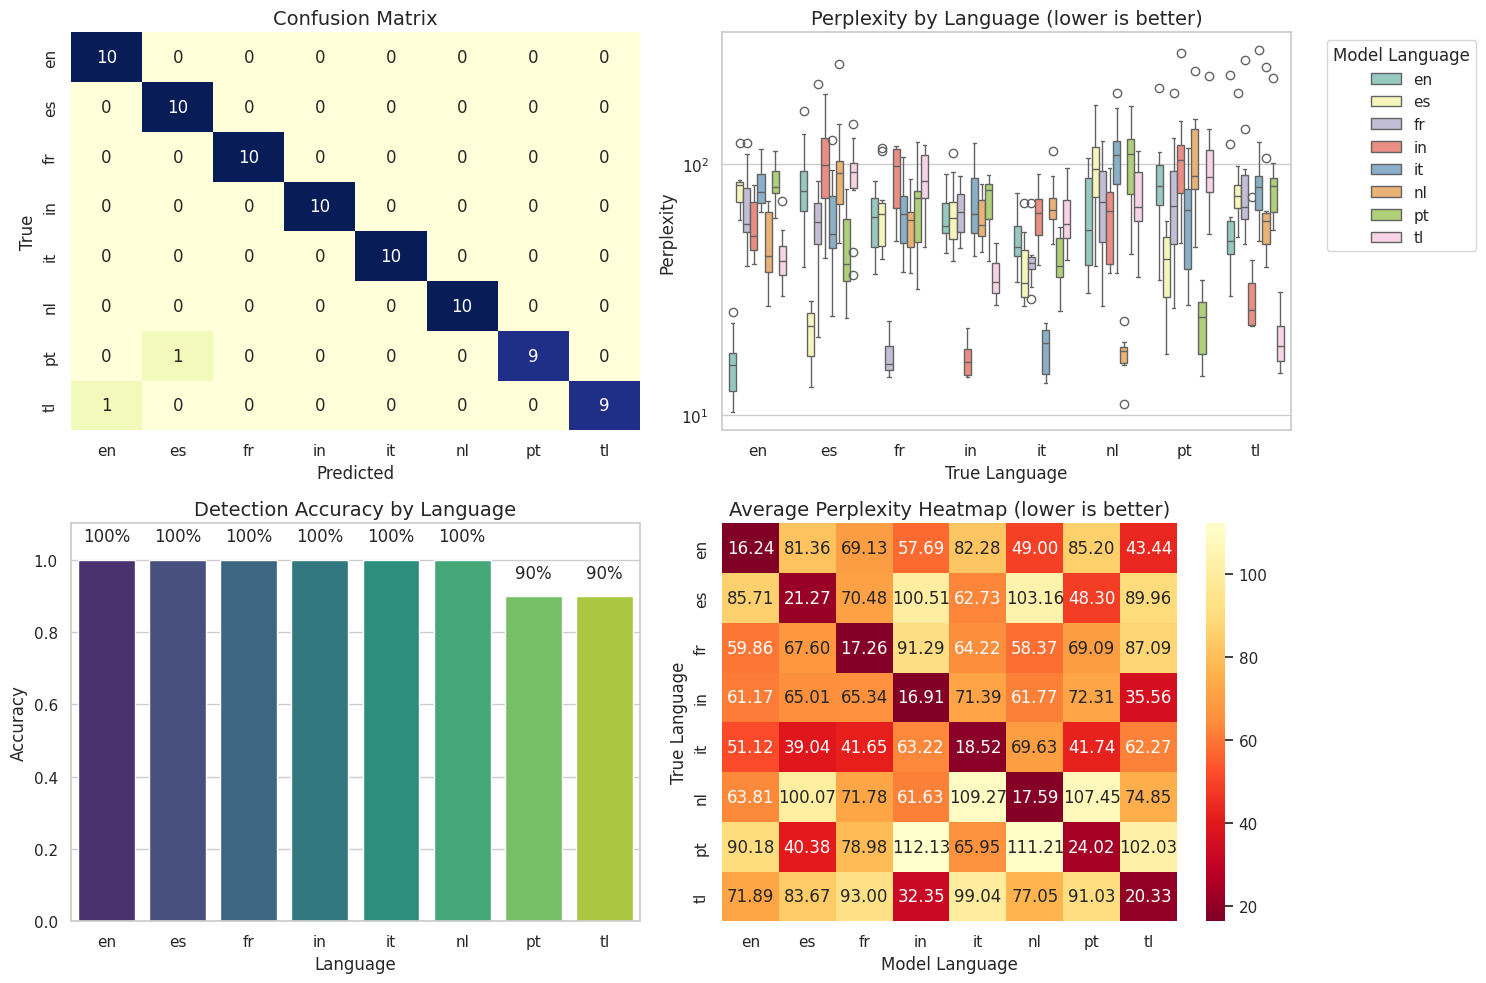

'language_detection_results.png'

In [26]:
# Generate visualizations
visualize_results(results_df)

# Testing

Copy the content of the **tests.py** file from the repo and paste below. This will create the results.json file and download it to your machine.

In [ ]:
# ########################################
# # PLACE TESTS HERE #
# # Create tests
# def test_preprocess():
#     return {
#         'vocab_length': len(preprocess()),
#     }

# def test_build_lm():
#     return {
#         'english_2_gram_length': len(build_lm('en', 2, True)),
#         'english_3_gram_length': len(build_lm('en', 3, True)),
#         'french_3_gram_length': len(build_lm('fr', 3, True)),
#         'spanish_3_gram_length': len(build_lm('es', 3, True)),
#     }

# def test_eval():
#     lm = build_lm('en', 3, True)
#     return {
#         'en_on_en': round(eval(lm, 'en', 3), 2),
#         'en_on_fr': round(eval(lm, 'fr', 3), 2),
#         'en_on_tl': round(eval(lm, 'tl', 3), 2),
#         'en_on_nl': round(eval(lm, 'nl', 3), 2),
#     }

# def test_match():
#     df = match()
#     return {
#         'df_shape': df.shape,
#         'en_en_3': df[(df['source'] == 'en') & (df['target'] == 'en') & (df['n'] == 3)]['perplexity'].values[0],
#         'en_tl_3': df[(df['source'] == 'en') & (df['target'] == 'tl') & (df['n'] == 3)]['perplexity'].values[0],
#         'en_nl_3': df[(df['source'] == 'en') & (df['target'] == 'nl') & (df['n'] == 3)]['perplexity'].values[0],
#     }

# def test_generate():
#     return {
#         'english_2_gram': generate('en', 2, "I am", 20, 5),
#         'english_3_gram': generate('en', 3, "I am", 20, 5),
#         'english_4_gram': generate('en', 4, "I Love", 20, 5),
#         'spanish_2_gram': generate('es', 2, "Soy", 20, 5),
#         'spanish_3_gram': generate('es', 3, "Soy", 20, 5),
#         'french_2_gram': generate('fr', 2, "Je suis", 20, 5),
#         'french_3_gram': generate('fr', 3, "Je suis", 20, 5),
#     }

# TESTS = [test_preprocess, test_build_lm, test_eval, test_match, test_generate]

# # Run tests and save results
# res = {}
# for test in TESTS:
#     try:
#         cur_res = test()
#         res.update({test.__name__: cur_res})
#     except Exception as e:
#         res.update({test.__name__: repr(e)})

# with open('results.json', 'w') as f:
#     json.dump(res, f, indent=2)

# # Download the results.json file
# files.download('results.json')
# ########################################

Processed: en -> en, n=1, perplexity=37.86
Processed: en -> en, n=2, perplexity=22.31
Processed: en -> en, n=3, perplexity=29.16
Processed: en -> en, n=4, perplexity=66.44
Processed: en -> es, n=1, perplexity=40.00
Processed: en -> es, n=2, perplexity=29.89
Processed: en -> es, n=3, perplexity=62.37
Processed: en -> es, n=4, perplexity=268.99
Processed: en -> fr, n=1, perplexity=41.94
Processed: en -> fr, n=2, perplexity=31.40
Processed: en -> fr, n=3, perplexity=62.63
Processed: en -> fr, n=4, perplexity=233.31
Processed: en -> in, n=1, perplexity=40.78
Processed: en -> in, n=2, perplexity=31.87
Processed: en -> in, n=3, perplexity=83.88
Processed: en -> in, n=4, perplexity=371.80
Processed: en -> it, n=1, perplexity=39.85
Processed: en -> it, n=2, perplexity=29.87
Processed: en -> it, n=3, perplexity=65.41
Processed: en -> it, n=4, perplexity=277.10
Processed: en -> nl, n=1, perplexity=38.93
Processed: en -> nl, n=2, perplexity=29.42
Processed: en -> nl, n=3, perplexity=65.95
Process

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Show the local files, results.json should be there now and
# also downloaded to your local machine
!ls -l

total 12
drwxr-xr-x 3 root root 4096 Apr 27 19:43 data
-rw-r--r-- 1 root root  878 Apr 27 20:29 results.json
drwxr-xr-x 1 root root 4096 Apr 24 18:20 sample_data
